### UR5e with RG2 gripper and D435 on Husky

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mujoco_parser import MuJoCoParserClass
from util import r2quat,rpy2r,r2rpy
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.6]


### Parse `scene_husky_ur5e_rg2_d435.xml`

In [2]:
xml_path = '../asset/husky_ur5e/scene_husky_ur5e_rg2_d435.xml'
env = MuJoCoParserClass(name='UR5e',rel_xml_path=xml_path,VERBOSE=True)

dt:[0.0020] HZ:[500]
n_dof (=nv):[22]
n_geom:[59]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[24]
body_names:['world', 'base_husky', 'front_left_wheel_link', 'front_right_wheel_link', 'rear_left_wheel_link', 'rear_right_wheel_link', 'base_ur5e', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'd435i', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link']
n_joint:[17

### Render

Pressed ESC
Quitting.


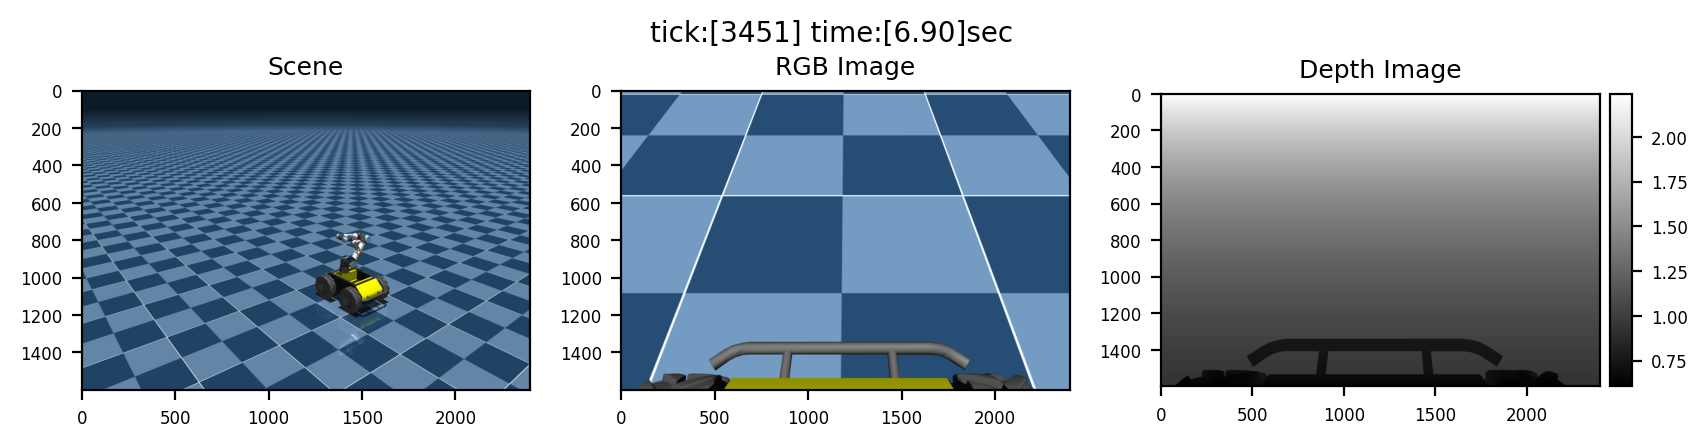

In [4]:
env.init_viewer(viewer_title='UR5e on Husky',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=-171,distance=3.0,elevation=-13,lookat=[0.11,0.01,0.6],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.2,jointwidth=0.05,
                  jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
# Indices for control
rev_joint_names_ur5 = [
    'shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
    'wrist_1_joint','wrist_2_joint','wrist_3_joint']
idxs_ur5_fwd = [env.model.joint(jname).qposadr[0] for jname in rev_joint_names_ur5]
idxs_ur5_step = [env.ctrl_joint_names.index(jname) for jname in rev_joint_names_ur5]
rev_joint_names_husky = [
    'front_left_wheel','front_right_wheel','rear_left_wheel','rear_right_wheel']
idxs_husky_step = [env.ctrl_joint_names.index(jname) for jname in rev_joint_names_husky]
idxs_rg2_step = [10] # gripper 

# UR initial position
q_ur_init = np.radians([-90,-130,120,100,45,-90])
env.forward(q=q_ur_init,joint_idxs=idxs_ur5_fwd)

# Loop
while (env.get_sim_time()<=1000) and env.is_viewer_alive():
    # Step
    FIX_HUSKY_BASE = False
    if FIX_HUSKY_BASE:
        ctrl = q_ur_init
        ctrl_idxs = idxs_ur5_step
    else:
        q_husky = np.array([1,1,1,1]) # move forward
        ctrl = np.append(q_ur_init,q_husky)
        ctrl_idxs = idxs_ur5_step+idxs_husky_step
    # Gripper
    ctrl = np.append(ctrl,1) # 0:close gripper, 1:open gripper
    ctrl_idxs = ctrl_idxs + idxs_rg2_step
    env.step(ctrl=ctrl,ctrl_idxs=ctrl_idxs)
    
    # Camera
    if env.loop_every(HZ=10):
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=50,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        scene_img = env.grab_image()
    
    # Render
    if env.loop_every(HZ=10):
        # env.update_viewer(lookat=env.get_p_body('base_husky'))
        env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                   PLOT_AXIS=True,axis_len=1.0,axis_width=0.005)
        env.plot_T(p=np.array([0,0,1]),R=np.eye(3,3),PLOT_AXIS=False,
                   label="Tick:[%d] Time:[%.1f]sec"%(env.tick,env.get_sim_time()))
        env.plot_body_T(body_name='base_husky',
                        PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
        env.plot_body_T(body_name='camera_center',
                        PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_body_T(body_name='tcp_link',
                        PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
        env.plot_contact_info(h_arrow=0.3,rgba_arrow=[1,0,0,1],PRINT_CONTACT_BODY=False)
        for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        env.render()

# Close viewer
env.close_viewer()

# Plot the final scene and egocentric images
fig,axs = plt.subplots(1,3,figsize=(10,2.3),gridspec_kw={'width_ratios': [1,1,1.05]})
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img); axs[0].set_title('Scene',fontsize=9)
axs[1].imshow(rgb_img); axs[1].set_title('RGB Image',fontsize=9)
im = axs[2].imshow(depth_img,cmap='gray'); axs[2].set_title('Depth Image',fontsize=9)
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)
fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=10)
plt.show()